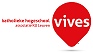<br>


**INTRODUCTION TO ARTIFICIAL INTELLIGENCE**<br>
Academiejaar 2021-2022<br>
Stefaan Haspeslagh<br>
Andy Louwyck<br>
Pieter Ideler

---



---



# Maze: Optimal Search

## Inleiding

Het doolhofprobleem is een veel gebruikt probleem om zoekalgoritmen op uit te testen. Een doolhof is een rooster met n x n vakken. Een vak kan een barrière bevatten, dit zijn vakjes waarop niet kan 'gewandeld' worden.
De uitdaging is om, gegeven een startpositie (links onder in het voorbeeld), een pad naar het doel te vinden (rechts boven in het voorbeeld).
Mogelijke richtingen waarin gewandeld kan worden (in die volgorde!) zijn: links, rechts, naar boven en naar onder. Diagonaal kan er niet gewandeld worden.

In deze notebook passen we de state-space representation van het doolhofprobleem die we in de vorige topics hebben uitgewerkt toe om optimal search algoritmes te implementeren. We starten bij **Uniform Cost** en voegen stap voor stap de verschillende extensies toe die in de theorie worden besproken, om uiteindelijk tot het **A*-algoritme** te komen.

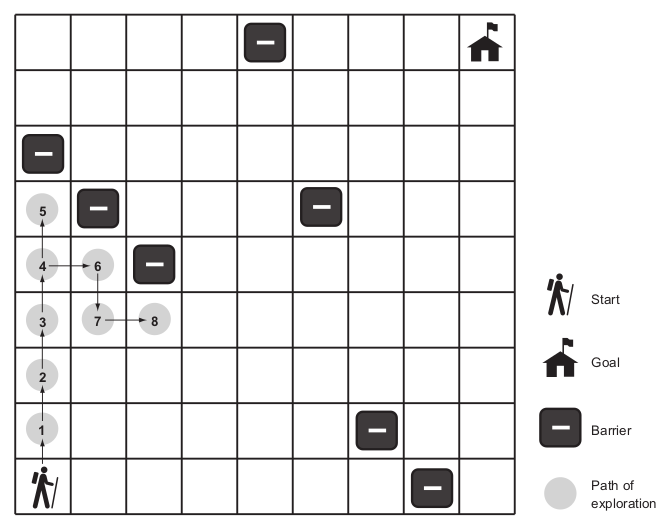

## State-Space Representation - Revisited

### OO-model

We implementeren een generiek OO-model waarin de volgende concepten van de state-space representation een plaats krijgen:

**state**

Houdt specifieke informatie omtrent de toestand van een zoekprobleem bij. We modelleren dit als een abstracte klasse `State`. Objecten van dit type stellen dan verschillende toestanden van het probleem voor. Voor elk nieuw zoekprobleem zal je een nieuwe klasse moeten ontwerpen die overerft van deze abstracte klasse. Op een state worden de production rules toegepast waaruit dan één move wordt geselecteerd die wordt toegepast op de state om in een nieuwe state te komen.

**goal**

Van elke toestand moeten we kunnen evalueren of dit de doeltoestand van het probleem is. We voorzien hiervoor een functie `is_goal()` in de generieke klasse `State`.

**production rule**

De production rules beschrijven welke 'acties' er kunnen uitgevoerd worden vanuit een state. De production rules formuleren dit eenduidig onafhankelijk van de state. Bijvoorbeeld: vanuit een willekeurig vakje zijn de mogelijke acties een stap naar links, naar rechts, naar boven of naar onder. We maken voor dit concept een klasse `ProductionRule` aan. Concrete rules voor een specifiek probleem moeten hiervan overerven. Het toepassen van een *rule* op een *state* wordt voorgesteld door de functie `apply(self, state) -> Move` en resulteert in een `Move`.

**move**

Een move is zoals hierboven aangehaald een concrete verandering van een welgedefinieerde toestand naar een nieuwe toestand. Dit concept wordt voorgesteld door een klasse `Move`. Een move is één van de production rules die wordt toegepast op een gegeven state. Klasse `Move` krijgt daarom bij instantiatie een welbepaald `State` object en een `ProductionRule` object mee. Een move kan soms niet geldig zijn; dit wordt gecheckt met de methode `is_valid`. Denk aan het doolhofprobleem: als je bijv. in de linkerkolom staat, dan kan je niet naar links bewegen. Met de functie `apply()` pas je de `rule` toe op de `state` en krijg je de nieuwe toestand, een nieuw `State` object dus. Zoals je gezien hebt in de theorie kan er een kost verbonden zijn aan het veranderen van de toestand. Die `cost` modelleren we nu al. Bij *blind search* is deze kost nog niet relevant, in verdere topics zal die wel gebruikt worden.

**path**

Een pad, gemodelleerd met de klasse `Path`, is een opeenvolging van toestanden, die begint bij de initiële toestand, en hopelijk eindigt in de doeltoestand (goal). Daarom moet je op een pad de functie `reaches_goal()` kunnen oproepen die controleert of een pad eindigt in de goal. Paden moeten ook kunnen gecontroleerd worden op *loops* met de methode `has_loop()`. Vanuit een bepaald pad moet je alle kinderen kunnen oproepen. De kinderen van een pad bekom je door het pad uit te breiden met alle mogelijke afstammelingen van de laatste toestand op het pad. Dit is geïmplementeerd in de methode `calculate_children()`. Let op: bij het berekenen van de kinderen zijn loops toegelaten! Verder heeft elke pad een lengte (property `length`): dit is het aantal toestanden (knopen) op het pad. De methode `add(self, state)` is een hulpmethode om een pad uit te breiden naar een nieuwe toestand en dus een nieuw pad te maken.

De OO-structuur biedt een generiek kader waarin we verschillende zoekproblemen kunnen formuleren. In commentaar wordt meer info gegeven over de ontwerpbeslissingen in dit model.

In [15]:
# eerst importeren we de nodige Python packages, modules, klassen en functies
from abc import ABC, abstractmethod

In [17]:
# superklasse Move
class Move:
    
    def __init__(self, state, rule, cost=1):
        # state is een State object
        # rule is een ProductionRule object
        self.state = state
        self.rule = rule
        self.cost = cost
    
    def is_valid(self):
        # Checkt of de Move self geldig is.
        # Retourneert True of False.
        return self.state.is_valid_move(self)
    
    def apply(self):
        # Past Move self toe op toestand state en geeft een nieuw State object terug
        return self.state.apply_move(self)

In [18]:
# superklasse ProductionRule
class ProductionRule:
    
    def apply(self, state) -> Move:
        # methode die een Move object teruggeeft om ProductionRule self op self.state toe te kunnen passen
        return Move(state, self)

In [19]:
# abstracte superklasse State
class State(ABC):

    rules = []  # list met ProductionRule objecten
    
    def apply_production_rules(self):
        # Op een state wordt deze methode aangeroepen met de production rules om
        # de moves te berekenen die het probleem in een nieuwe toestand kunnen brengen.
        # Deze functie geeft dus een lijst van moves terug.
        return [rule.apply(self) for rule in self.rules]

    @abstractmethod
    def is_valid_move(self, move):
        # Het toepassen van een move op een state kan leiden tot een ongeldige toestand.
        # Deze functie controleert of een state al dan niet een geldige toestand van het probleem is.
        # Retourneert dus een boolean.
        pass
    
    @abstractmethod
    def apply_move(self, move):
        # Op een state kan een move toegepast worden om naar een volgende state over te gaan.
        # Deze functie geeft dus een nieuwe state terug.
        pass
    
    @abstractmethod
    def is_goal(self):
        # Controleert of een state de `goal state` is.
        # Retourneert dus een booleaanse waarde.
        pass
    
    @abstractmethod
    def __eq__(self, other):
        # Vergelijkt toestand self met een andere toestand other
        # nodig om te checken of er al dan niet loops zijn in een pad
        pass

In [20]:
# superklasse Path
class Path:
    
    def __init__(self, *states, cost=0):
        self.cost = cost # geaccumuleerd cost bijhouden
        self.states = states # een path is een opeenvolging van toestanden
    
    @property
    def length(self):
        # Geeft de lengte van het pad terug, dit is het aantal knopen op het pad,
        # dus het aantal toestanden dat bereikt worden op het pad
        return len(self.states)
    
    def has_loop(self):
        # Een pad bevat een 'loop' indien er twee toestanden op het pad gelijk zijn aan elkaar
        # aangezien de zoekalgoritmen telkens 'loops' verwijderen uit de queue
        # kan er enkel een loop ontstaan indien het pad uitgebreid wordt,
        # dus volstaat het enkel de laatst toegevoegde toestand op het pad te vergelijken met de voorgaande.
        return any([self.states[-1] == other for other in self.states[:-1]])
    
    def contains_state(self, state):
        # controleert of een pad langs een bepaalde toestand 'passeert'
        return state in self.states

    def reaches_goal(self):
        # Controleert of het pad naar de goaltoestand leidt.
        # Roept dus de methode is_goal() op de laatste toestand op het pad op.
        return self.states[-1].is_goal()

    def calculate_children(self):
        # Activeert de "production rules" op de laatste state, om nieuwe afstammelingen (descendants)
        # te genereren. De paden naar die nieuwe descendants zijn de kinderen van het huidige pad (self).
        # Let op! Die paden kunnen loops bevatten!
        moves = self.states[-1].apply_production_rules()
        return [self.__extend(move.apply(), move.cost) for move in moves if move.is_valid()]
    
    def last_state(self):
        return self.states[-1]
    
    def __extend(self, state, cost):
        # Voegt een toestand toe aan het huidige pad.
        # Geeft dus een nieuw pad terug, dat leidt tot de opgegeven toestand.
        return Path(*self.states, state, cost=self.cost+cost)
    
    def __repr__(self):
        # Een pad is een opeenvolging van states.
        # De generieke string-voorstelling van een pad is dus de string-voorstelling van die states.
        states = ", ".join([str(state) for state in self.states])
        return f"[{states}]"

### Implementatie voor doolhof

We kunnen nu ons specifieke doolhofprobleem implementeren door specifieke subklassen te definiëren die erven van de superklassen uit het generieke OO-model dat we hierboven hebben geïmplementeerd.

Aan de hand van de *positie* (`Position`), wat het vakje is waar we staan, en de *configuratie* van het doolhof (`Maze`) definiëren we een specifiek **move** in het doolhof m.b.v. klasse `MazeMove` die erft van `Move`. 

Om vanuit een *state* verschillende *moves* te genereren implementeren we de **production rules** m.b.v. klassen die erven van `ProductionRule`:
- `Left`
- `Right`
- `Up`
- `Down`

De uiteindelijke klasse `MazeState` implementeert dan de **state** m.b.v. alle voorgaande klasses. De **state** wordt gedefinieerd a.d.h.v. een positie in het doolhof, vandaar dat klasse `MazeState` attributen `position` en `maze` bevat. Klasse `MazeState` erft van `State` en moet alle abstracte methoden implementeren. 

In [21]:
# eerst importeren we de nodige Python packages, modules, klassen en functies
from IPython.display import clear_output
from time import sleep
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

In [22]:
# klasse Position
class Position:
  
    def __init__(self, irow, icol):
        # Een positie definiëren we adhv rij index irow en kolom index icol van het vakje
        self.irow = irow
        self.icol = icol

    def __eq__(self, other):
        # Twee posities zijn hetzelfde als hun rij en kolom indices gelijk zijn
        return self.irow == other.irow and self.icol == other.icol
    
    def __repr__(self):
        # String voorstelling van de positie: (irow, icol)
        return "({}, {})".format(self.irow, self.icol)

In [23]:
# klasse Maze met de doolhofconfiguratie
class Maze:
   
    symbols = ('*', '.', '#', 'o')  # start = *, free = ., wall = #, goal = o 
    
    def __init__(self, grid):
        # grid is een integer array:
        # start = 0, free = 1, wall = 2, goal = 3
        self.grid = np.array(grid)
        self.size = self.grid.shape[0]  # aantal rijen = aantal kolommen van het doolhof rooster

    def get_start_position(self):
        # Retourneert startpositie (= Position object)
        irow, icol = np.where(self.grid == 0)
        return Position(irow[0], icol[0])

    def get_goal_position(self):
        # Retourneert eindpositie (= Position object)
        irow, icol = np.where(self.grid == 3)
        return Position(irow[0], icol[0])
    
    def is_valid_position(self, position):
        # Checkt of een positie geldig is: moet binnen het grid liggen en mag geen barrière zijn
        return (0 <= position.irow < self.size and
                0 <= position.icol < self.size and 
                self.grid[position.irow, position.icol] != 2)
    
    def plot(self):
        # Plot het doolhof
        cmap = colors.ListedColormap(['forestgreen', 'lightyellow', 'purple', 'red'])  # colormap
        bounds = np.linspace(-0.5, 3.5, 5)
        norm = colors.BoundaryNorm(bounds, cmap.N)
        # plot grid
        plt.matshow(self.grid, cmap=cmap, norm=norm)
        # axes
        xmax = self.size - 0.5
        ymax = self.size - 0.5
        ax = plt.gca()
        ax.set_aspect("equal")
        ax.set_xticks(np.linspace(-0.5, xmax, self.size + 1))
        ax.set_xticklabels([])
        ax.set_yticks(np.linspace(-0.5, ymax, self.size + 1))
        ax.set_yticklabels([])
        ax.tick_params(axis=u'both', which=u'both', length=0)
        # plot grid and set axis limits
        plt.grid()
        plt.xlim([-0.5, xmax])
        plt.ylim([ymax, -0.5])
        
    def __repr__(self):
        # String representatie van het doolhof
        return "\n".join([''.join([self.symbols[item] for item in row]) for row in self.grid])

    @staticmethod
    def create(maze):
        # Creëert grid adhv list van list met strings "maze"
        # Retourneert een Maze object
        return Maze(grid=[[Maze.symbols.index(symbol) for symbol in row] for row in maze])

In [24]:
# klasse MazeProductionRule die erft van klasse ProductionRule
class MazeProductionRule(ProductionRule):

    def __init__(self, drow=0, dcol=0):
        # Een production rule in dit geval is één vakje naar links, rechts, boven of onder opschuiven
        # De nieuwe positie heeft coördinaat (irow+drow, icol+dcol)
        super().__init__()
        self.drow = drow
        self.dcol = dcol

    def __repr__(self):
        # We stellen de production rule voor als 'left', 'right', 'up' of 'down'.
        if self.dcol == -1:
            return 'left'
        if self.dcol == 1:
            return 'right'
        if self.drow == -1:
            return 'up'
        if self.drow == 1:
            return 'down'

# subklassen Left, Right, Up, Down
class Left(MazeProductionRule):
    def __init__(self):
        super().__init__(0, -1)

class Right(MazeProductionRule):
    def __init__(self):
        super().__init__(0, 1)

class Up(MazeProductionRule):
    def __init__(self):
        super().__init__(-1, 0)

class Down(MazeProductionRule):
    def __init__(self):
        super().__init__(1, 0)

In [25]:
# klasse MazeMove die erft van klasse Move
class MazeMove(Move):

    def __init__(self, state, rule):
        super().__init__(state, rule)
    
    def __repr__(self):
        # Een Move kunnen we op dezelfde manier voorstellen als de overeenkomstige ProductionRule
        return str(self.rule)

In [26]:
# klasse MazeState die erft van State
class MazeState(State):

    rules = [Left(), Right(), Up(), Down()]  # alle mogelijke acties, in die volgorde!
    
    def __init__(self, maze, position, *rules):
        # Een toestand wordt gekenmerkt door positie in het doolhof
        # vandaar attributen maze en position 
        super().__init__()
        self.maze = maze
        self.position = position
        if rules:
            self.rules = rules

    def is_valid_move(self, move):
        # Checkt of move leidt tot een geldige positie in self.maze
        new_position = Position(self.position.irow + move.rule.drow,
                                self.position.icol + move.rule.dcol)
        return self.maze.is_valid_position(new_position)
    
    def apply_move(self, move):
        # Past move toe op State self om een nieuwe State te krijgen
        new_position = Position(self.position.irow + move.rule.drow,
                                self.position.icol + move.rule.dcol)
        return MazeState(self.maze, new_position, *self.rules)
    
    def is_goal(self):
        # Checkt of State self de eindtoestand is
        return self.maze.get_goal_position() == self.position
    
    def get_position(self):
        return self.position
    
    def set_production_rules(self, *rules):
        # rules is input lijst met production rules objecten
        self.rules = rules # [r for r in rules]
    
    def __eq__(self, other):
        # State self is gelijk aan State other als hun posities gelijk zijn
        return self.position == other.position
    
    def __repr__(self):
        # String voorstelling van de State self is de positie
        return str(self.position)

Voor de visualisatie van een pad voorzien we een aparte klasse `MazePathPlotter` met twee methodes:
- `plot`: plot direct het volledige pad
- `plot_dynamic`: plot het pad stap voor stap

In [27]:
# klasse MazePathPlotter
class MazePathPlotter:
    
    def __init__(self, path):
        self.path = path  # Path object met states en dus posities
    
    def plot(self):
        state = self.path.states[-1]
        state.maze.plot()
        x = np.arange(0, state.maze.grid.size)
        plt.plot(x[state.position.icol], x[state.position.irow], 'bo')
        positions = [state.position for state in self.path.states[:-1]]
        irow = np.array([position.irow for position in positions])
        icol = np.array([position.icol for position in positions])
        if len(positions) > 0:
            plt.plot(x[icol], x[irow], 'ko')
            
    def plot_dynamic(self, wait=0.5):
        state = self.path.states[-1]
        x = np.arange(0, state.maze.grid.size)
        icol, irow = [], []
        for position in [state.position for state in self.path.states]:
            state.maze.plot()
            irow.append(position.irow)
            icol.append(position.icol)
            plt.plot(x[icol], x[irow], 'ko')
            plt.show()
            sleep(wait)
            clear_output()
        self.plot()  

### DFS en BFS

Aan de hand van het OO-model implementeren we DFS en BFS. Deze functie kan op gelijk welke implementatie van de `Path` klasse toegepast worden.

In [ ]:
from time import time

def dfs_bfs(initial_path, method='dfs'):
# initial_path is Path object containing the initial state
# method is 'dfs' or 'bfs'

    # start time
    starttime = time()
    
    # keep track of the number of iterations
    nr_iterations = 0

    # 1. queue <- path only containing the root
    queue = [initial_path]

    # initialize length queue
    length_queue = [len(queue)]

    # 2. while (queue is not empty and goal is not reached)
    goal_is_reached = initial_path.reaches_goal()
    path_to_goal = None
    while queue and not goal_is_reached:
        
        # augment number of iterations
        nr_iterations = nr_iterations + 1
        
        # length queue
        length_queue.append(len(queue))
        
        # remove the first path from the queue
        first_path = queue.pop(0)

        # create new paths (to all children)
        # reject the new paths with loops
        new_paths = [path for path in first_path.calculate_children() if not path.has_loop()]

        # if method is DFS: add the new paths to the FRONT of the queue
        if method.lower() == 'dfs':
            queue = new_paths + queue
        # if method is BFS: add the new paths to the BACK of the queue
        elif method.lower() == 'bfs':
            queue = queue + new_paths

        # update goal_is_reached
        for path in new_paths:
            if path.reaches_goal():
                goal_is_reached = True
                path_to_goal = path

    # 3. if (goal reached) then success else failure
    print("SUCCES" if goal_is_reached else "FAILURE")

    # print elapsed time, number of iterations, and maximum length of queue
    print("Elapsted time:", time() - starttime, 'seconds')
    print('Number of iterations:', nr_iterations)
    print('Maximum length of queue:', max(length_queue))
    
    # return path to goal if goal is reached and None otherwise
    return path_to_goal


### Voorbeeld BFS

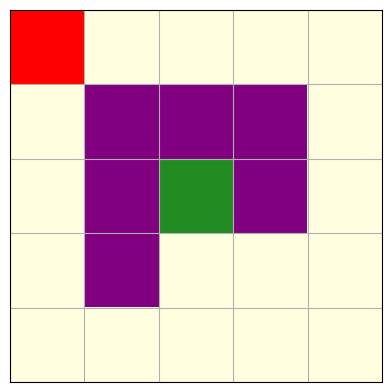

In [28]:
maze = Maze.create(['o....',
                    '.###.',
                    '.#*#.',
                    '.#...',
                    '.....'])

maze.plot()

In [ ]:
initial_state = MazeState(maze, maze.get_start_position())
initial_path = Path(initial_state)
initial_path.cost  # paden hebben nu ook een cost! Dat van het initial path is uiteraard 0

In [ ]:
path_to_goal = dfs_bfs(initial_path, 'bfs')

In [ ]:
print(path_to_goal)

In [ ]:
path_plotter = MazePathPlotter(path_to_goal)
path_plotter.plot()

In [ ]:
path_plotter.plot_dynamic()

### Heuristische functies

Wanneer we heuristische zoekalgoritmes willen gaan toepassen om ons doolhofprobleem op te lossen, dan hebben we een heuristische functie nodig. In het geval van een doolhof kunnen we de **Manhattan afstand** gebruiken. Wie hier meer uitleg over wil, en zich bijvoorbeeld afvraagt waarom deze afstand naar Manhattan is vernoemd, verwijzen we door naar Wikipedia: https://nl.wikipedia.org/wiki/Manhattan-metriek. Merk op dat daar de term 'metriek' wordt gebruikt, wat een wiskundige veralgemening is van het begrip 'afstand'.

In het geval van ons doolhof definiëren we de Manhattan afstand als het aantal vakjes dat een gegeven vakje verwijderd is van ons eindvakje. De formule is eenvoudig. Stel dat het gegeven vakje een coördinaat heeft gelijk aan `(irow, icol)` en het eindvakje een coördinaat gelijk aan `(irow_goal, icol_goal)`, dan is de Manhattan afstand:

> `manhattan_distance = abs(irow_goal - irow) + abs(icol_goal - icol)`

De figuur hieronder stelt dit grafisch voor, met het rode vakje de eindpositie en het groene vakje de gegeven positie. In dit geval is de Manhattan distance gelijk aan 4 + 5 = 9.

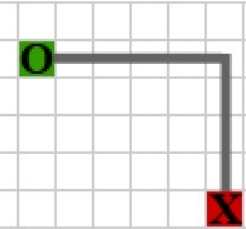

We definiëren hier een functie voor, die we dan als inputargument kunnen doorgeven aan onze zoekalgoritmes. Merk op dat we een `MazeState` object als input argument geven.

In [29]:
def manhattan_distance(maze_state: MazeState):
    goal_position = maze_state.maze.get_goal_position()
    state_position = maze_state.get_position()
    return abs(goal_position.irow - state_position.irow) + abs(goal_position.icol - state_position.icol)

We maken een eenvoudige maze aan, en testen de functie op een initiële toestand.

In [ ]:
maze = Maze.create(["*..", ".#.", "..o"])
maze.plot()

In [ ]:
initial_state = MazeState(maze, maze.get_start_position())

In [ ]:
manhattan_distance(initial_state)

## Opdracht 1: Implementeer uniform cost

Implementeer nu de functie `uc(initial_path)`. Gebruik de functie `dfs_bfs` als basis, maar sorteer de `queue` o.b.v. de geaccumuleerde kost van de paden: `path.cost`. Zoals we in vorig topic over "heuristic search" hebben gezien, gebruiken we hiervoor functie `sorted`. Check bijv. de code van het greedy search algoritme:

```python
# sort the entire queue using the heuristic function
queue = sorted(queue, key=lambda path: heuristic(path.last_state()))
```

We moeten hier dus hetzelfde doen, maar nu sorteren o.b.v. `path.cost` ipv functie `heuristic` toepassen op de laatste state.

Hoe wordt die geaccumuleeerde kost trouwens berekend? Wel, bij elk vakje dat we opschuiven wordt `1` bij de kost van het pad geteld. Dat komt omdat `Move.cost` standaard gelijk is aan `1`.

In [30]:
from time import time

def uc(initial_path):
# initial_path is Path object containing the initial state

    # start time
    starttime = time()
    
    # keep track of the number of iterations
    nr_iterations = 0

    # 1. queue <- path only containing the root
    queue = [initial_path]

    # initialize length queue
    length_queue = [len(queue)]

    # 2. while (queue is not empty and goal is not reached)
    goal_is_reached = initial_path.reaches_goal()
    path_to_goal = None
    while queue and not goal_is_reached:
        
        # augment number of iterations
        nr_iterations = nr_iterations + 1
        
        # length queue
        length_queue.append(len(queue))
        
        # remove the first path from the queue
        first_path = queue.pop(0)

        # create new paths (to all children)
        # reject the new paths with loops
        new_paths = [path for path in first_path.calculate_children() if not path.has_loop()]

        # add the new paths to the queue
        queue = new_paths + queue
        
        # sort the new path using the accumulated cost
        queue = sorted(queue, key=lambda path: path.cost)

        # update goal_is_reached
        for path in new_paths:
            if path.reaches_goal():
                goal_is_reached = True
                path_to_goal = path
                break

    # 3. if (goal reached) then success else failure
    print("SUCCES" if goal_is_reached else "FAILURE")

    # print elapsed time, number of iterations, and maximum length of queue
    print("Elapsted time:", time() - starttime, 'seconds')
    print('Number of iterations:', nr_iterations)
    print('Maximum length of queue:', max(length_queue))
    
    # return path to goal if goal is reached and None otherwise
    return path_to_goal

#### Uittesten van `uc`

We testen nu de geïmplementeerde functie `uc` uit.

In [ ]:
maze = Maze.create(['o....',
                    '.###.',
                    '.#*#.',
                    '.#...',
                    '.....'])
initial_state = MazeState(maze, maze.get_start_position())
initial_path = Path(initial_state)

In [ ]:
uc_path_to_goal = uc(initial_path)
print("Cost of path to goal:", uc_path_to_goal.cost)
MazePathPlotter(uc_path_to_goal).plot()

We testen het algoritme ook uit op het complexere doolhof:

In [ ]:
maze = Maze.create(['....#...o',
                    '.........',
                    '#........',
                    '.#...#...',
                    '..#......',
                    '.........',
                    '.........',
                    '......#..',
                    '*......#.'])

maze.plot()

initial_state = MazeState(maze, maze.get_start_position())
initial_path = Path(initial_state)

In [ ]:
uc_path_to_goal = uc(initial_path)
MazePathPlotter(uc_path_to_goal).plot()

Na een tijd onderbreken we de berekening, want die duurt te lang... Hoogtijd dus om het algoritme te verbeteren! 

## Opdracht 2: Implementeer optimal uniform cost

Implementeer nu de functie `ouc(initial_path)` met het Optimal Uniform Cost algoritme. Gebruik de voorgaande functie als basis en pas het stopcriterium aan. Dat is het volgende stuk code waarin werd gecheckt of één van de nieuwe paden de goal bereikt:

```python
# update goal_is_reached
for path in new_paths:
    if path.reaches_goal():
        goal_is_reached = True
        path_to_goal = path
        break
```

We gaan nu niet alle paden in de queue checken maar enkel het eerste pad in de queue. Wat is het eerste pad in de `queue`? Inderdaad, `queue[0]`.

In [33]:
from time import time

def ouc(initial_path):
# initial_path is Path object containing the initial state

    # start time
    starttime = time()
    
    # keep track of the number of iterations
    nr_iterations = 0

    # 1. queue <- path only containing the root
    queue = [initial_path]

    # initialize length queue
    length_queue = [len(queue)]

    # 2. while (queue is not empty and goal is not reached)
    goal_is_reached = initial_path.reaches_goal()
    path_to_goal = None
    while queue and not goal_is_reached:
        
        # augment number of iterations
        nr_iterations = nr_iterations + 1
        
        # length queue
        length_queue.append(len(queue))
        
        # remove the first path from the queue
        first_path = queue.pop(0)

        # create new paths (to all children)
        # reject the new paths with loops
        new_paths = [path for path in first_path.calculate_children() if not path.has_loop()]

        # add the new paths to the queue
        queue = new_paths + queue
        
        # sort the new path using the accumulated cost
        queue = sorted(queue, key=lambda path: path.cost)

        # update goal_is_reached, check only first path!
        if queue[0].reaches_goal():
            goal_is_reached = True
            path_to_goal = queue[0]

    # 3. if (goal reached) then success else failure
    print("SUCCES" if goal_is_reached else "FAILURE")

    # print elapsed time, number of iterations, and maximum length of queue
    print("Elapsted time:", time() - starttime, 'seconds')
    print('Number of iterations:', nr_iterations)
    print('Maximum length of queue:', max(length_queue))
    
    # return path to goal if goal is reached and None otherwise
    return path_to_goal

#### Uittesten van `ouc`

We testen nu de geïmplementeerde functie `ouc` uit.

In [31]:
maze = Maze.create(['o....',
                    '.###.',
                    '.#*#.',
                    '.#...',
                    '.....'])
initial_state = MazeState(maze, maze.get_start_position())
initial_path = Path(initial_state)

SUCCES
Elapsted time: 0.0012869834899902344 seconds
Number of iterations: 44
Maximum length of queue: 9
Cost of path to goal: 8


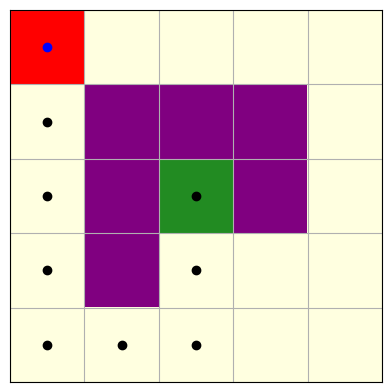

In [34]:
ouc_path_to_goal = ouc(initial_path)
print("Cost of path to goal:", ouc_path_to_goal.cost)
MazePathPlotter(ouc_path_to_goal).plot()

## Opdracht 3: Implementeer de branch and bound extension

Om branch and bound te kunnen implementeren, moeten we eerst wat Python syntax aanleren. 

We gaan gebruik maken van een variabele `bound` die we initialiseren met een zeer grote waarde. We kunnen zelfs gebruik maken van de waarde `inf` in NumPy, wat staat voor "plus oneindig":  

In [39]:
import numpy as np

bound = np.inf
bound

inf

De `bound` aanpassen kunnen we doen m.b.v. de functie `min`. We simuleren de `cost` van de paden m.b.v. de functie `randint`.

In [ ]:
from random import randint, seed

seed(200)

bound = np.inf
for i in range(1000):
    cost = randint(10, 1000)  # random cost tussen 10 en 1000
    bound = min(bound, cost)
bound

Stel nu dat we een lijst hebben met getallen en we willen alle getallen eruit gooien die groter zijn dan of gelijk aan `bound`, dan kunnen we dat met een lus doen: 

In [ ]:
lst = [1, 5, 10, 20, 100, 30, 3, 7, 11, 1000]

new_lst = []
for n in lst:
    if n < bound:
        new_lst.append(n)
new_lst

Maar we kunnen ook gebruik maken van de `filter` functie:

In [ ]:
list(filter(lambda n: n < bound, lst))

*Opdrachtje*

Maak nu een lijst aan met getallen van 1 t.e.m. 10. Herinner je dat je daarvoor gebruik kan maken van `range`. Maak dan gebruik van functie `filter` om een lijst `even` en `oneven` aan te maken met resp. de even en oneven getallen uit de oorspronkelijke lijst met getallen.  

In [ ]:
getallen = list(range(1, 11))
print(getallen)

even = list(filter(lambda n: n%2 == 0, getallen))
print(even)

oneven = list(filter(lambda n: n%2 == 1, getallen))
print(oneven)

Implementeer nu de functie `ouc_bb(initial_path)`. Gebruik de voorgaande functie als basis, en pas de tips toe die we hierboven hebben uitgelegd. Na het sorteren van de `queue` moeten we de `bound` gaan updaten a.d.h.v. de cost van de nieuwe paden die zijn gegenereerd en die de goal bereiken. Daarna moeten we de paden uit de `queue` halen met een cost die groter is dan of gelijk aan de geüpdatete `bound`. 

In [40]:
from time import time

def ouc_bb(initial_path):
# initial_path is Path object containing the initial state

    # start time
    starttime = time()
    
    # keep track of the number of iterations
    nr_iterations = 0

    # 1. queue <- path only containing the root
    queue = [initial_path]

    # initialize length queue
    length_queue = [len(queue)]

    # 2. while (queue is not empty and goal is not reached)
    goal_is_reached = initial_path.reaches_goal()
    path_to_goal = None
    bound = np.inf # no bound
    while queue and not goal_is_reached:
        
        # augment number of iterations
        nr_iterations = nr_iterations + 1
        
        # length queue
        length_queue.append(len(queue))
        
        # remove the first path from the queue
        first_path = queue.pop(0)

        # create new paths (to all children)
        # reject the new paths with loops
        new_paths = [path for path in first_path.calculate_children() if not path.has_loop()]

        # add the new paths to the queue
        queue = new_paths + queue
        
        # sort the new path using the accumulated cost
        queue = sorted(queue, key=lambda path: path.cost)
        
        # to update bound,
        # check if one of the new path has reached goal
        for path in new_paths:
            if path.reaches_goal():
                bound = min(path.cost, bound)
    
        # remove longer paths
        # queue = 
        list(filter(lambda path: path.cost <= bound, queue))

        # update goal_is_reached, check only first path!
        if queue[0].reaches_goal():
            goal_is_reached = True
            path_to_goal = queue[0]

    # 3. if (goal reached) then success else failure
    print("SUCCES" if goal_is_reached else "FAILURE")

    # print elapsed time, number of iterations, and maximum length of queue
    print("Elapsted time:", time() - starttime, 'seconds')
    print('Number of iterations:', nr_iterations)
    print('Maximum length of queue:', max(length_queue))
    
    # return path to goal if goal is reached and None otherwise
    return path_to_goal

#### Uittesten van `ouc_bnb`

We testen nu de geïmplementeerde functie `ouc_bb` uit.

In [41]:
maze = Maze.create(['o....',
                    '.###.',
                    '.#*#.',
                    '.#...',
                    '.....'])
initial_state = MazeState(maze, maze.get_start_position())
initial_path = Path(initial_state)

SUCCES
Elapsted time: 0.0016241073608398438 seconds
Number of iterations: 44
Maximum length of queue: 9
Cost of path to goal: 8


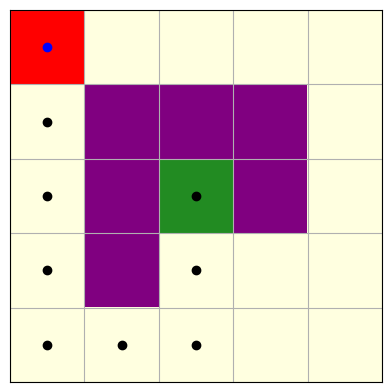

In [42]:
ouc_bb_path_to_goal = ouc_bb(initial_path)
print("Cost of path to goal:", ouc_path_to_goal.cost)
MazePathPlotter(ouc_bb_path_to_goal).plot()

KeyboardInterrupt: 

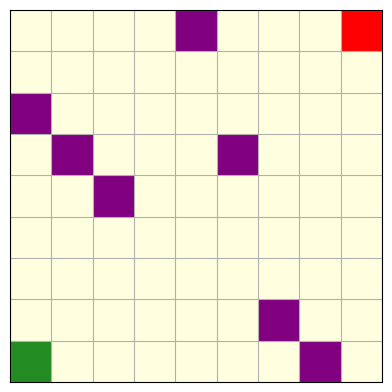

In [43]:
maze = Maze.create(['....#...o',
                    '.........',
                    '#........',
                    '.#...#...',
                    '..#......',
                    '.........',
                    '.........',
                    '......#..',
                    '*......#.'])

maze.plot()

initial_state = MazeState(maze, maze.get_start_position())
initial_path = Path(initial_state)

ouc_bb_path_to_goal = ouc_bb(initial_path)
print("Cost of path to goal:", ouc_path_to_goal.cost)
MazePathPlotter(ouc_bb_path_to_goal).plot()

## Opdracht 4: Implementeer estimate-extended uniform cost

Implementeer nu de functie `ouc_ee(initial_path, heuristic)`. Gebruik de functie `ouc` als basis. Inputparameter `heuristic` is een functie om de heuristische waarde te berekenen. Wij gebruiken hier de functie `manhattan_distance`.

Herinner je dat Optimal Uniform Cost de `queue` sorteerde o.b.v. de geaccumuleerde kost van de paden in de `queue`:

```python
# sort the new path using the accumulated cost
queue = sorted(queue, key=lambda path: path.cost)
```

Bij estimate-extended uniform cost moeten we sorteren op de f-waarde, die de som is van de geaccumuleerde kost en de heuristische waarde h. Die laatste berekenen we als volgt:

```python
heuristic(path.last_state())
```

In [45]:
from time import time

def ouc_ee(initial_path, heuristic):
# initial_path is Path object containing the initial state

    # start time
    starttime = time()
    
    # keep track of the number of iterations
    nr_iterations = 0

    # 1. queue <- path only containing the root
    queue = [initial_path]

    # initialize length queue
    length_queue = [len(queue)]

    # 2. while (queue is not empty and goal is not reached)
    goal_is_reached = initial_path.reaches_goal()
    path_to_goal = None
    while queue and not goal_is_reached:
        
        # augment number of iterations
        nr_iterations = nr_iterations + 1
        
        # length queue
        length_queue.append(len(queue))
        
        # remove the first path from the queue
        first_path = queue.pop(0)

        # create new paths (to all children)
        # reject the new paths with loops
        new_paths = [path for path in first_path.calculate_children() if not path.has_loop()]

        # add the new paths to the queue
        queue = new_paths + queue
        
        # sort the new path using the f-value
        queue = sorted(queue, key=lambda path: path.cost + heuristic(path.last_state()))

        # update goal_is_reached, check only first path!
        if queue[0].reaches_goal():
            goal_is_reached = True
            path_to_goal = queue[0]

    # 3. if (goal reached) then success else failure
    print("SUCCES" if goal_is_reached else "FAILURE")

    # print elapsed time, number of iterations, and maximum length of queue
    print("Elapsted time:", time() - starttime, 'seconds')
    print('Number of iterations:', nr_iterations)
    print('Maximum length of queue:', max(length_queue))
    
    # return path to goal if goal is reached and None otherwise
    return path_to_goal

#### Uittesten van `ouc_ee`

We testen nu de geïmplementeerde functie `ouc_ee` uit. Door gebruik te maken van de f-waarde wordt de rekentijd drastisch verminderd waardoor we nu het complexere doolhof als test case kunnen gebruiken!

In [46]:
maze = Maze.create(['....#...o',
                    '.........',
                    '#........',
                    '.#...#...',
                    '..#......',
                    '.........',
                    '.........',
                    '......#..',
                    '*......#.'])
initial_state = MazeState(maze, maze.get_start_position())
initial_path = Path(initial_state)

SUCCES
Elapsted time: 0.0013511180877685547 seconds
Number of iterations: 17
Maximum length of queue: 17
Cost of path to goal: 16


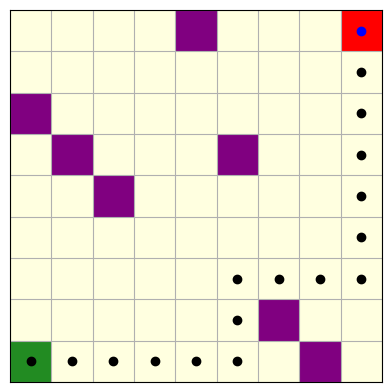

In [47]:
ee_path_to_goal = ouc_ee(initial_path, manhattan_distance)
print("Cost of path to goal:", ee_path_to_goal.cost)
MazePathPlotter(ee_path_to_goal).plot()

## Opdracht 5: Implementeer A* = ouc_ee + redundant path deletion

Implementeer nu de functie `a_star(initial_path, heuristic)`. Gebruik de voorgaande functie als basis en voeg redundant path deletion toe. Dit is de code:

```python
# redundant path deletion
to_remove = []
for p, q in itertools.permutations(queue, 2):
    I = p.last_state()    
    if q.contains_state(I):
        cost_p = p.cost
        cost_q = q.cost
        if cost_p >= cost_q:
            to_remove.append(p)
queue = [q for q in queue if not q in to_remove]
```

Wat doet nu die functie `permutations` uit module `itertools`? Die geeft alle mogelijke combinaties van 2 elementen uit de `queue`:

In [48]:
import itertools

lst = [1, 2, 3]
for pair in itertools.permutations(lst, 2):
    print(pair)

(1, 2)
(1, 3)
(2, 1)
(2, 3)
(3, 1)
(3, 2)


We zien dat de volgorde belangrijk is, aangezien `(1, 2)` niet hetzelfde is als `(2, 1)`. En dat moet ook zo zijn bij redundant path deletion! Je kan trouwens functie `combinations` gebruiken als de volgorde niet belangrijk is.

*Opdrachtje*

Geef alle mogelijke combinaties van 2 letters van het woord 'Python'. De volgorde speelt geen rol.

In [ ]:
for letters in itertools.combinations('Python', 2):
    print(letters)

Implementeer nu de functie `a_star(initial_path, heuristic)`.

In [49]:
from time import time
import itertools

def a_star(initial_path, heuristic):
# initial_path is Path object containing the initial state

    # start time
    starttime = time()
    
    # keep track of the number of iterations
    nr_iterations = 0

    # 1. queue <- path only containing the root
    queue = [initial_path]

    # initialize length queue
    length_queue = [len(queue)]

    # 2. while (queue is not empty and goal is not reached)
    goal_is_reached = initial_path.reaches_goal()
    path_to_goal = None
    while queue and not goal_is_reached:
        
        # augment number of iterations
        nr_iterations = nr_iterations + 1
        
        # length queue
        length_queue.append(len(queue))
        
        # remove the first path from the queue
        first_path = queue.pop(0)

        # create new paths (to all children)
        # reject the new paths with loops
        new_paths = [path for path in first_path.calculate_children() if not path.has_loop()]

        # add the new paths to the queue
        queue = new_paths + queue
        
        # sort the new path using the accumulated cost
        queue = sorted(queue, key=lambda path: path.cost + heuristic(path.last_state()))
        
        # redundant path deletion
        to_remove = []
        for p, q in itertools.permutations(queue, 2):
            I = p.last_state()
            
            if q.contains_state(I):
                cost_p = p.cost
                cost_q = q.cost
            
                if cost_p >= cost_q:
                    to_remove.append(p)
                
        queue = [q for q in queue if not q in to_remove]

        # update goal_is_reached, check only first path!
        if queue[0].reaches_goal():
            goal_is_reached = True
            path_to_goal = queue[0]

    # 3. if (goal reached) then success else failure
    print("SUCCES" if goal_is_reached else "FAILURE")

    # print elapsed time, number of iterations, and maximum length of queue
    print("Elapsted time:", time() - starttime, 'seconds')
    print('Number of iterations:', nr_iterations)
    print('Maximum length of queue:', max(length_queue))
    
    # return path to goal if goal is reached and None otherwise
    return path_to_goal

#### Uittesten van `a_star`

We testen nu de geïmplementeerde functie `a_star` uit.

In [50]:
maze = Maze.create(['....#...o',
                    '.........',
                    '#........',
                    '.#...#...',
                    '..#......',
                    '.........',
                    '.........',
                    '......#..',
                    '*......#.'])
initial_state = MazeState(maze, maze.get_start_position())
initial_path = Path(initial_state)

SUCCES
Elapsted time: 0.005421161651611328 seconds
Number of iterations: 17
Maximum length of queue: 15
Cost of path to goal: 16


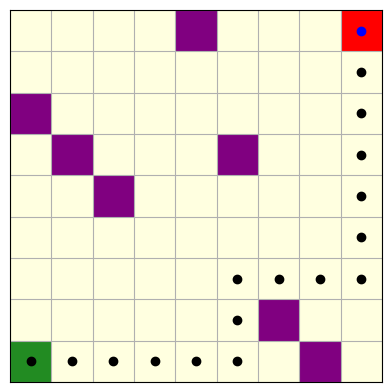

In [51]:
a_star_path_to_goal = a_star(initial_path, manhattan_distance)
print("Cost of path to goal:", a_star_path_to_goal.cost)
MazePathPlotter(a_star_path_to_goal).plot()

Het aantal iteraties is hetzelfde als bij estimate-extended uniform cost, maar we zien dat de redundant path deletion zijn werk doet, want de maximale lengte van de `queue` is hier 15 ipv 17!